# Обучение и тест модели MLPModel
1. Подготовка данных ф-ия MLPDataset из dataset.py
2. Определение функции потерь и оптимизатора (MSE - среднеквадратичная ошибка,SGD - стохастический градиентный спуск)
3. Обучение модели
4. Обучение и тестирование на Кросс-Валидации, тк у нас очень маленькая выборка


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np

from sklearn.model_selection import KFold

from linRegres import MLPModel
from dataset import MLPDataset,MLPTesDataset


In [24]:
#Импорт модели
model = MLPModel()
#MSE
criterion = nn.MSELoss()  
# Стохастический градиентный спуск
optimizer = optim.SGD(model.parameters(), lr=0.1)  #Епсилон = 0.1 с учетом нашего датасета [-1;1] это приемлемое значение

# Получение датасета и DataLoader
equalDataset = MLPDataset()
dataset = equalDataset['dataset']
train_loader = equalDataset['train_loader']  # Этот DataLoader мы не используем напрямую

In [25]:
# Параметры
k_folds = 5  # Количество фолдов для кросс-валидации
epochs = 200  # Количество эпох обучения

def train_model(model_q, criterion_q, optimizer_q, train_loader_q, epochs_q):
    """
    Обучает модель с помощью данных из train_loader.

    Параметры:
    - model_q (torch.nn.Module): Обучаемая модель.
    - criterion_q (torch.nn): Функция потерь.
    - optimizer_q (torch.optim): Оптимизатор для обновления весов.
    - train_loader_q (DataLoader): DataLoader для итерации по обучающим данным.
    - epochs_q (int): Количество эпох для обучения.

    Возвращает:
    - train_losses (list): Список, содержащий среднюю потерю за каждую эпоху.
    """
    model_q.train()  # Перевод модели в режим обучения
    train_losses = []
    for epoch in range(epochs_q):
        epoch_loss = 0.0
        for inputs, labels in train_loader_q:
            optimizer_q.zero_grad()
            outputs = model_q(inputs)
            loss = criterion_q(outputs, labels)
            loss.backward()
            optimizer_q.step()
            epoch_loss += loss.item() * inputs.size(0)
        epoch_loss /= len(train_loader_q.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
    return train_losses

def test_model(model, criterion, test_loader):
    """
    Тестирует модель, используя данные из test_loader и вычисляет среднюю потерю.

    Параметры:
    - model (torch.nn.Module): Модель для тестирования.
    - criterion (torch.nn): Функция потерь.
    - test_loader (DataLoader): DataLoader для итерации по тестовым данным.

    Выводит:
    - Среднюю потерю на тестовом наборе.
    """
    model.eval()  # Переключаем модель в режим оценки
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

    avg_loss = total_loss / total_samples
    print(f'Средняя потеря на тестовом наборе: {avg_loss}')

def reset_weights(m):
    """
    Применяет реинициализацию весов к слоям модели.

    Параметры:
    - m (torch.nn.Module): Слой модели для реинициализации весов.

    Действие:
    - Инициализирует веса слоев Linear с использованием метода Kaiming и устанавливает небольшие начальные значения для bias.
    """
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
            

# Визуализация входных данных датасета
def plot_data(train_loader):
    """
    Визуализирует входные данные из DataLoader.

    Параметры:
    - train_loader (DataLoader): DataLoader, содержащий тренировочный датасет.
    """
    plt.figure(figsize=(10, 5))
    plt.title('Тренировочные данные')
    plt.xlabel('Вход X')
    plt.ylabel('Выход Y')
    for inputs, labels in train_loader:
        plt.scatter(inputs.numpy(), labels.numpy(), color='blue', alpha=0.5)
    plt.show()

# Построение результатов линейной регрессии в виде прямой линии
def plot_regression_line(model, test_loader):
    """
    Строит график входных данных и линейную регрессию, выполненную моделью.

    Параметры:
    - model (torch.nn.Module): Обученная модель.
    - test_loader (DataLoader): DataLoader, содержащий тестовый датасет.
    """
    model.eval()
    plt.figure(figsize=(10, 5))
    plt.title('Линейная регрессия')
    plt.xlabel('Вход X')
    plt.ylabel('Выход Y')

    inputs_all = torch.tensor([])
    labels_all = torch.tensor([])
    predictions_all = torch.tensor([])

    with torch.no_grad():
        for inputs, labels in test_loader:
            predictions = model(inputs)
            inputs_all = torch.cat((inputs_all, inputs), 0)
            labels_all = torch.cat((labels_all, labels), 0)
            predictions_all = torch.cat((predictions_all, predictions), 0)

    # Сортировка данных для корректного отображения линии регрессии
    sorted_indices = torch.argsort(inputs_all[:, 0])
    inputs_all = inputs_all[sorted_indices]
    labels_all = labels_all[sorted_indices]
    predictions_all = predictions_all[sorted_indices]

    # Отображение истинных данных и линии регрессии
    plt.scatter(inputs_all.numpy(), labels_all.numpy(), color='blue', alpha=0.5, label='Истинные значения')
    plt.plot(inputs_all.numpy(), predictions_all.numpy(), color='red', label='Линия регрессии')
    plt.legend()
    plt.show()


def plot_fold_losses(fold_losses):
    """
    Визуализирует потери на каждом фолде в процессе обучения.

    Параметры:
    - fold_losses (list of lists): Список списков потерь, где каждый внутренний список содержит историю потерь для одного фолда.
    """
    plt.figure(figsize=(10, 5))
    plt.title('Лосс функция по фолдам')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    for i, fold_loss in enumerate(fold_losses):
        plt.plot(fold_loss, label=f'Фолд {i+1}')
    plt.legend()
    plt.show()


           


FOLD 1
--------------------------------
Epoch 1, Loss: 0.13160038264468313
Epoch 2, Loss: 0.013133169384673238
Epoch 3, Loss: 0.010294503439217806
Epoch 4, Loss: 0.00809602770023048
Epoch 5, Loss: 0.007409568596631289
Epoch 6, Loss: 0.0069215948227792975
Epoch 7, Loss: 0.006202859478071332
Epoch 8, Loss: 0.006131679401732981
Epoch 9, Loss: 0.007402911712415516
Epoch 10, Loss: 0.005685511184856296
Epoch 11, Loss: 0.005948220007121563
Epoch 12, Loss: 0.006415807153098285
Epoch 13, Loss: 0.00593627046328038
Epoch 14, Loss: 0.005169093632139266
Epoch 15, Loss: 0.006150914635509252
Epoch 16, Loss: 0.005467422725632787
Epoch 17, Loss: 0.006166753615252674
Epoch 18, Loss: 0.005643365415744483
Epoch 19, Loss: 0.005044317524880171
Epoch 20, Loss: 0.005334293702617288
Epoch 21, Loss: 0.005013711703941226
Epoch 22, Loss: 0.005607671779580414
Epoch 23, Loss: 0.005564913584385068
Epoch 24, Loss: 0.005927045922726392
Epoch 25, Loss: 0.005331470211967826
Epoch 26, Loss: 0.004867081111297011
Epoch 27,

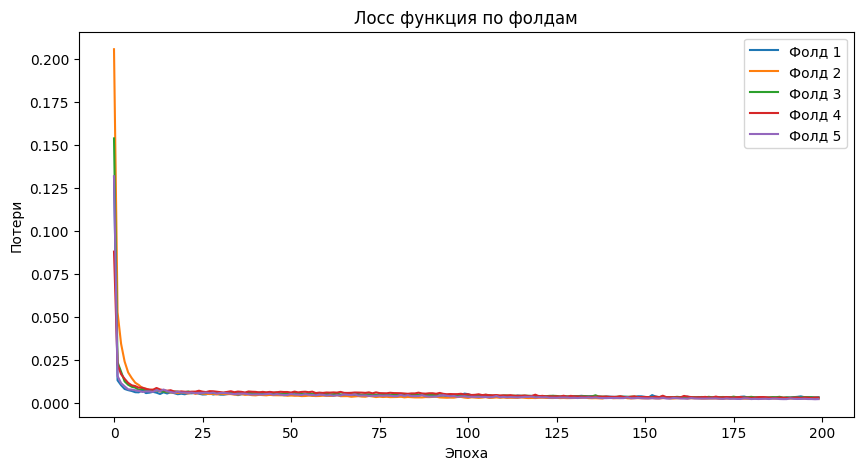

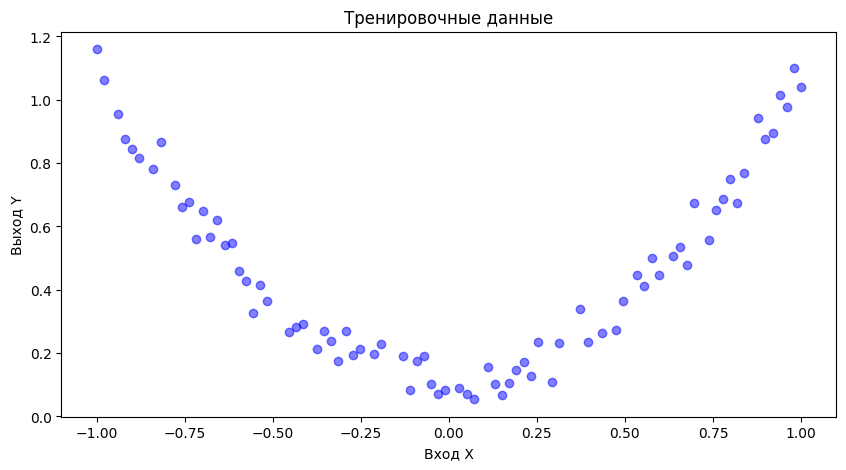

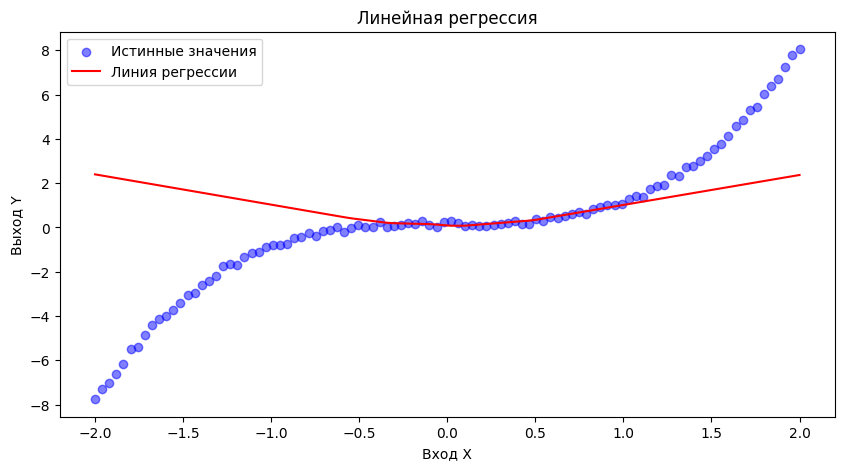

In [26]:
# Настройка KFold
kfold = KFold(n_splits=k_folds, shuffle=True)

fold_losses = []  # Список для хранения истории потерь для каждого фолда

# Запуск к-фолд кросс-валидации
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold+1}')
    print('--------------------------------')
    
    # Сэмплеры для обучающего и тестового набора
    train_subsampler = SubsetRandomSampler(train_ids)
    test_subsampler = SubsetRandomSampler(test_ids)
    
    # DataLoader'ы для текущего разбиения
    train_loader = DataLoader(dataset, batch_size=10, sampler=train_subsampler)
    test_loader = DataLoader(dataset, batch_size=10, sampler=test_subsampler)
    
    # Сброс параметров модели для нового фолда
    model.apply(reset_weights)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)  # Создание нового оптимизатора может быть также полезным для сброса моментов
    
    # Обучение модели и сохранение истории потерь
    fold_loss = train_model(model, criterion, optimizer, train_loader, epochs)
    fold_losses.append(fold_loss)
    
    # Тестирование модели
    model.eval()  # Перевод модели в режим оценки
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    print(f'Test Loss for fold {fold}: {total_loss / len(test_loader)}\n')
    
    
    
    
# Визуализация потерь для каждого фолда
plot_fold_losses(fold_losses)

# Визуализация входных данных
plot_data(train_loader)

# Визуализация результатов
test_data = MLPTesDataset()
test_loader = test_data['test_loader']
plot_regression_line(model, test_loader)

In [27]:
# Создание тестового набора данных
test_data = MLPTesDataset()
test_loader = test_data['test_loader']

# Проверка модели
test_model(model, criterion, test_loader)


Средняя потеря на тестовом наборе: 11.10518196830526


In [28]:
# Сохранение параметров модели
torch.save(model.state_dict(), 'mlp_model_params.pth')


'''
# Загрузка параметров модели
model = MLPModel()  
model.load_state_dict(torch.load('mlp_model_params.pth'))
model.eval()  # Перевод модели в режим оценки 
'''

"\n# Загрузка параметров модели\nmodel = MLPModel()  \nmodel.load_state_dict(torch.load('mlp_model_params.pth'))\nmodel.eval()  # Перевод модели в режим оценки \n"